In [1]:
! pip install autograd

In [2]:
import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"

In [3]:
import geomstats
import math
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.lie_group import *
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla
from geomstats.learning.denoising_geodesic import DenoisingGeodesic
from geomstats.geometry.general_linear import GeneralLinear
from shape_project import *

INFO: Using autograd backend


In [184]:
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.geometry.siegel import Siegel
gl=GeneralLinear(28)#,positive_det=True)


# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds.
## Authors: Marianne Arriola & Ryan Stofer

### Introduction and Background:

*INSERT BACKGROUND INFO HERE*

### Model Architecture:

*INSERT MODEL ARCHITECTURE INFO HERE*

### Data:

*INSERT DATA INFO HERE*

In [173]:
data, ids, target = load_connectomes()
print(data.shape)
print(ids)
print(target)

spd = SPDMatrices(28)
spd_affine = SPDAffineMetric(28)

(86, 28, 28)
[120873 135376 139149 146791 153870 167403 179564 179614 180172 191161
 197297 199397 216806 222333 224755 244353 259678 267327 273218 273762
 275939 277945 290112 293046 295807 298608 323839 337260 348851 403692
 404156 427131 427246 438939 441598 459624 467185 468228 468930 469535
 472665 474861 479741 495307 508321 522766 529803 537342 542571 558698
 559296 570576 573811 581828 582211 597203 609291 617191 641748 702920
 712549 737494 752943 767901 774591 775909 794470 797181 806111 818142
 823981 829335 835522 862050 867297 879556 906283 907482 909442 932646
 933065 934330 950671 963924 993348 993946]
[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1]


In [66]:
bool_list = list(map(bool,target))
flip_bool_list = [not elem for elem in bool_list]
schiz = data[bool_list]
print(schiz.shape)
schiz_spd = spd.projection(schiz)
healthy = data[flip_bool_list]
print(healthy.shape)
healthy_spd = spd.projection(healthy)

(40, 28, 28)
(46, 28, 28)


### Noise Scheduler

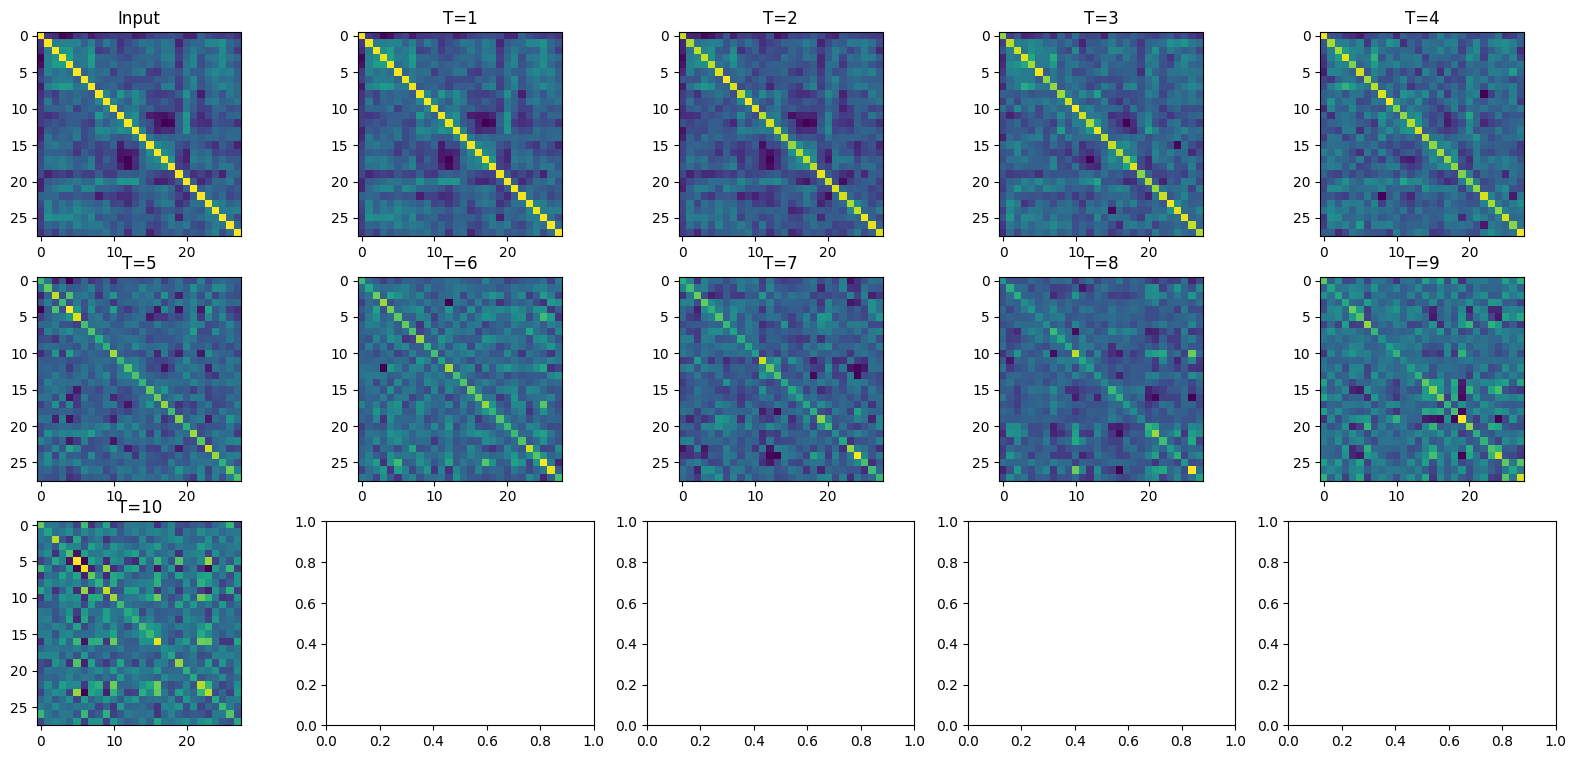

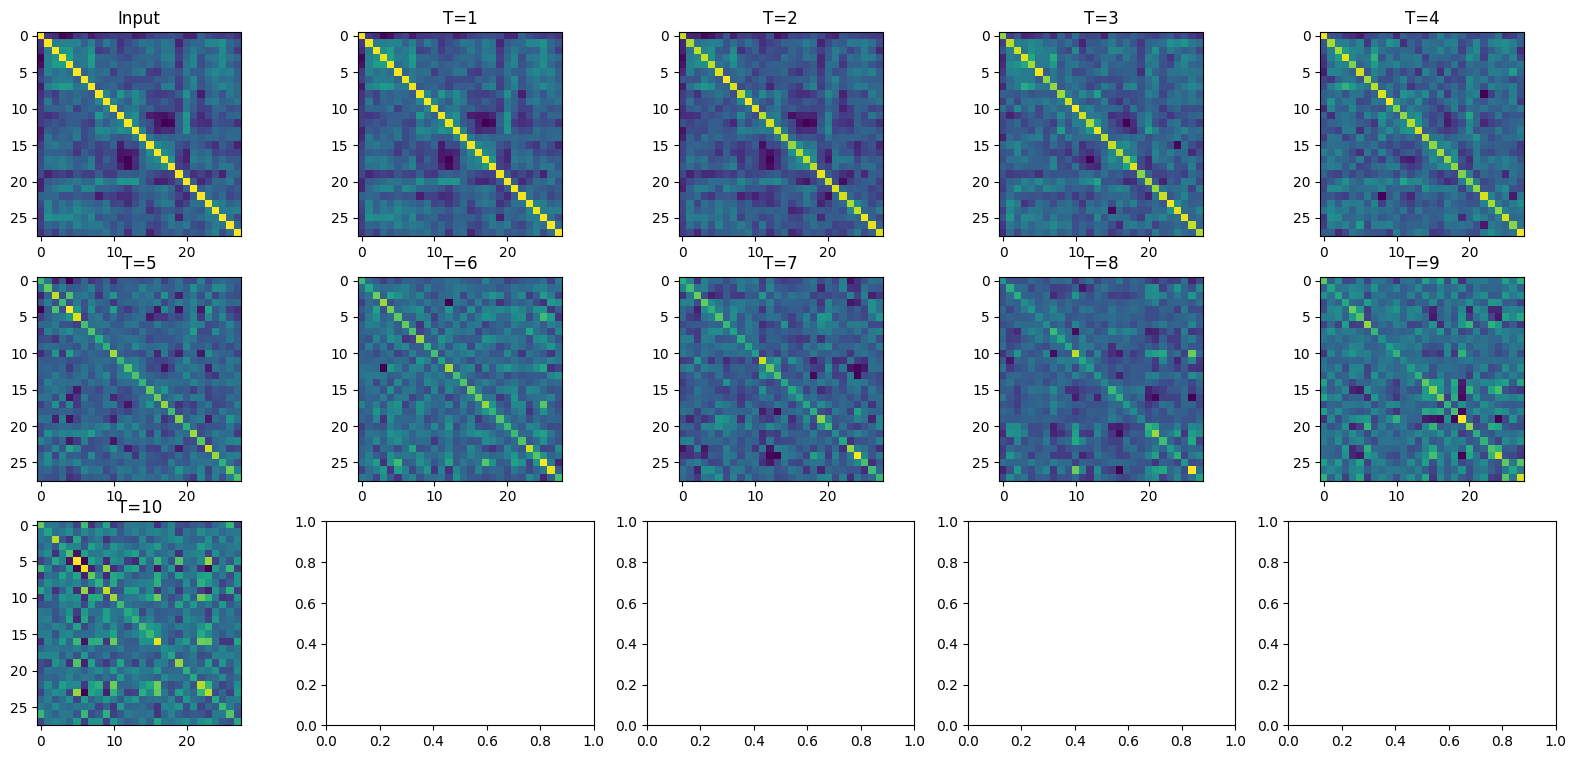

In [202]:
## Example forward diffusion process
# Define beta schedule
T = 10
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = gs.cumprod(alphas, axis=0)
alphas_cumprod_prev = gs.pad(alphas_cumprod[:-1], (1, 0))
alphas_cumprod_prev[0] = 1
sqrt_recip_alphas = gs.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = gs.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = gs.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def forward_diffusion_sample(x_0, t, noise_level=0.4, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    symm_noise = np.random.standard_normal(x_0.shape)
    symm_noise = np.tril(symm_noise) + np.tril(symm_noise, -1).T
    noisy_tangent_vec = symm_noise#*noise_level
  
    to_reach = x_0*sqrt_alphas_cumprod[t]
    noisy_tangent = spd.metric.log(to_reach,x_0)
    noisy_geodesic = spd.metric.geodesic(initial_tangent_vec=noisy_tangent, initial_point=x_0)

    # sample noisy sample along geodesic
    noisy_sample = noisy_geodesic(1.0)
    noisy_sample = spd.metric.exp((sqrt_one_minus_alphas_cumprod[t] * symm_noise),noisy_sample)
    
    # noisy_sample = input_sample @ x ; solve for denoising x
    return noisy_sample

for t in range(T):
    if t == 0:
        noisy_mats = forward_diffusion_sample(healthy_spd[20], t)
    else:
        noisy_mats = gs.concatenate((noisy_mats,forward_diffusion_sample(healthy_spd[20], t)),axis=0)
plot_mats(healthy_spd[20],noisy_mats,5)

In [105]:
## Collect training/testing samples

y_trains, y_tests, y_cleans = [], [], []
for ind,sample in enumerate(healthy_spd[:20]):
    noisy_samples,denoising_mats = forward_diffusion_sample(sample, T)
    #if gs.any(gs.isnan(denoising_mats)):
    #    continue
    
    # train/test split
    if ind < 20:
        y_trains.append(denoising_mats)
        y_cleans.append(noisy_samples)
    elif ind < 20:
        y_tests.append(sample)


In [153]:
gr = DenoisingGeodesic(
    space=gl, metric=gl.metric, verbose = True,
    center_X=False, method="riemannian", initialization="warm_start",max_iter=100, tol=1e-5, init_step_size=1e-3)
    
gr.intercept_ = y_trains[0][-1]  # theta0
'''
for m in range(0,T-1):
    if m == 0:
        logs = unsqueeze(gl.metric.log(y_trains[0][m+1], y_trains[0][m]))
    else:
        logs = gs.concatenate((logs,unsqueeze(gl.metric.log(y_trains[0][-2], y_trains[0][-1]))))
'''
gr.coef_ = gl.metric.log(y_trains[0][-1], y_trains[0][-2]) # theta1
print(gr.intercept_.shape,gr.coef_.shape)

(28, 28) (28, 28)


In [154]:
## Train model
x_train = np.linspace(0, T, T)
x_train = np.squeeze(x_train)
for ind,y_train in enumerate(y_trains):
    gr.fit(x_train,y_train,y_cleans)
    #gr.intercept_ = y_train[0]
    #gr.coef_ = gl.metric.log(y_train[-2], y_train[-1])

INFO: Tolerance threshold reached at iter 10
INFO: Number of gradient evaluations: 12, Number of gradient iterations: 10 loss at termination: 2.3565753632892902e-06
INFO: Tolerance threshold reached at iter 1
INFO: Number of gradient evaluations: 1, Number of gradient iterations: 1 loss at termination: 9.012578634615812e-08
INFO: Tolerance threshold reached at iter 1
INFO: Number of gradient evaluations: 1, Number of gradient iterations: 1 loss at termination: 9.012578634611204e-08
INFO: Tolerance threshold reached at iter 1
INFO: Number of gradient evaluations: 1, Number of gradient iterations: 1 loss at termination: 9.01257863458063e-08
INFO: Tolerance threshold reached at iter 1
INFO: Number of gradient evaluations: 1, Number of gradient iterations: 1 loss at termination: 9.012578634605875e-08
INFO: Tolerance threshold reached at iter 1
INFO: Number of gradient evaluations: 1, Number of gradient iterations: 1 loss at termination: 9.0125786346107e-08
INFO: Tolerance threshold reached

generated distance to true healthy: 2344.777839293212 noisy distance: 1680.919103476213
generated distance to true schizophrenic: 2393.6299267487466 noisy distance: 2600.398509881582


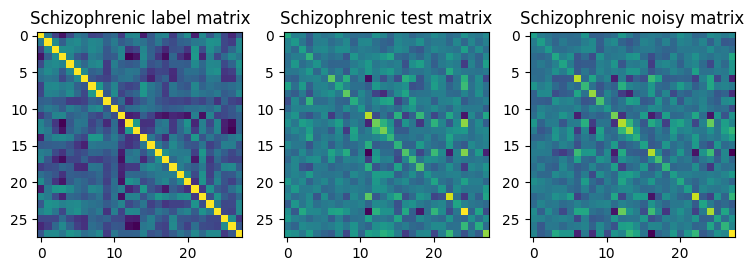

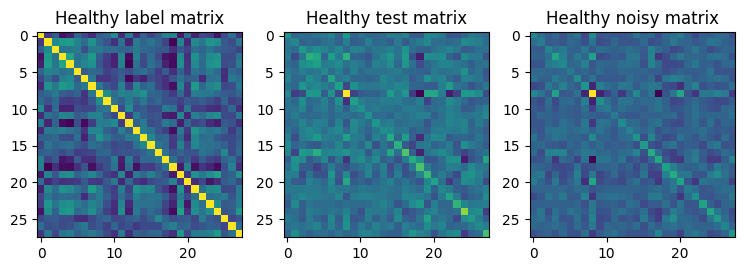

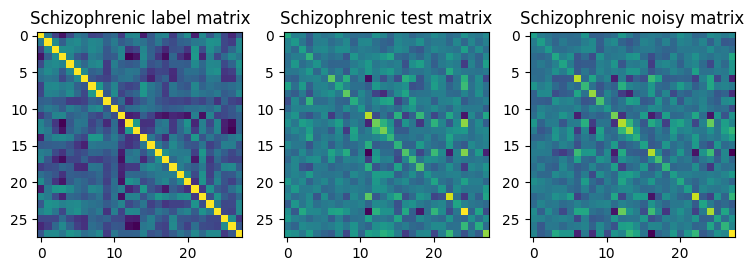

In [155]:
## Evaluation
h_label = healthy_spd[19]
s_label = schiz_spd[10]

def denoise(x,y_):
    preds = []
    # given clean test example, retrieve noisy samples
    y,dn = forward_diffusion_sample(y_, T)

    # begin denoising noisy sample
    to_denoise = y[-2]
    
    for m in range(1,x.shape[0]+1):
        # use previous denoised prediction for next denoising
        t_in = np.array([x[(y.shape[0]-m)]])
        
        # predict denoising matrix to predict clean sample at next time step
        if m == 1:
            denoisers = gr._model(t_in,gr.coef_,gr.intercept_)[0]
        else:
            denoisers = gr._model(t_in, gr.coef_, denoisers)[0]
        #denoisers = gr.predict(t_in)[0]#,gr.coef_,gr.intercept_)[0]

        if m != 1:
            to_denoise = preds[-1]

        preds.append(to_denoise@denoisers)#+  (np.random.standard_normal(to_denoise.shape)*0.05))

        # record losses
        distances = gl.metric.squared_dist(preds[-1], y_)

    return preds, distances, y, denoisers

h_preds, distances, noisy_y, denoisers = denoise(x_train,h_label)
print('generated distance to true healthy:',distances, 'noisy distance:', gl.metric.squared_dist(noisy_y[-1], h_label))
plot_results(h_label,h_preds[-1],noisy_y[-1],'Healthy')

s_preds, distances, noisy_y, denoisers = denoise(x_train,s_label)
print('generated distance to true schizophrenic:',distances, 'noisy distance:', gl.metric.squared_dist(noisy_y[-1], s_label))
plot_results(s_label,s_preds[-1],noisy_y[-1],'Schizophrenic')



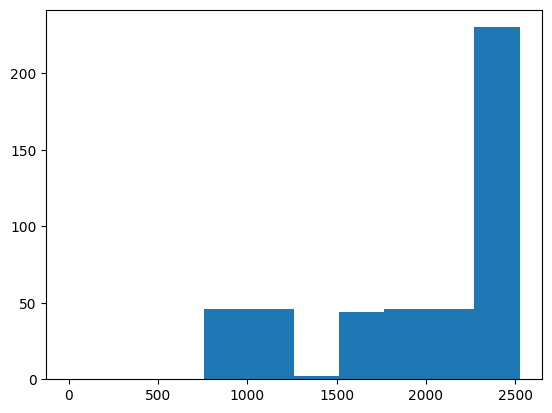

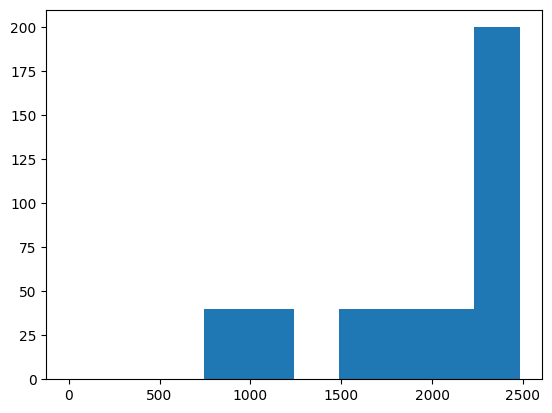

In [156]:
#f, axarr = plt.subplots(2,1)
sqrd_dist=compute_sqr_dist(h_preds, healthy_spd, gl.metric)
plt.hist(sqrd_dist,range=(0,np.max(sqrd_dist)))
plt.show()

sqrd_dist=compute_sqr_dist(h_preds, schiz_spd, gl.metric)
plt.hist(sqrd_dist,range=(0,np.max(sqrd_dist)))
plt.show()


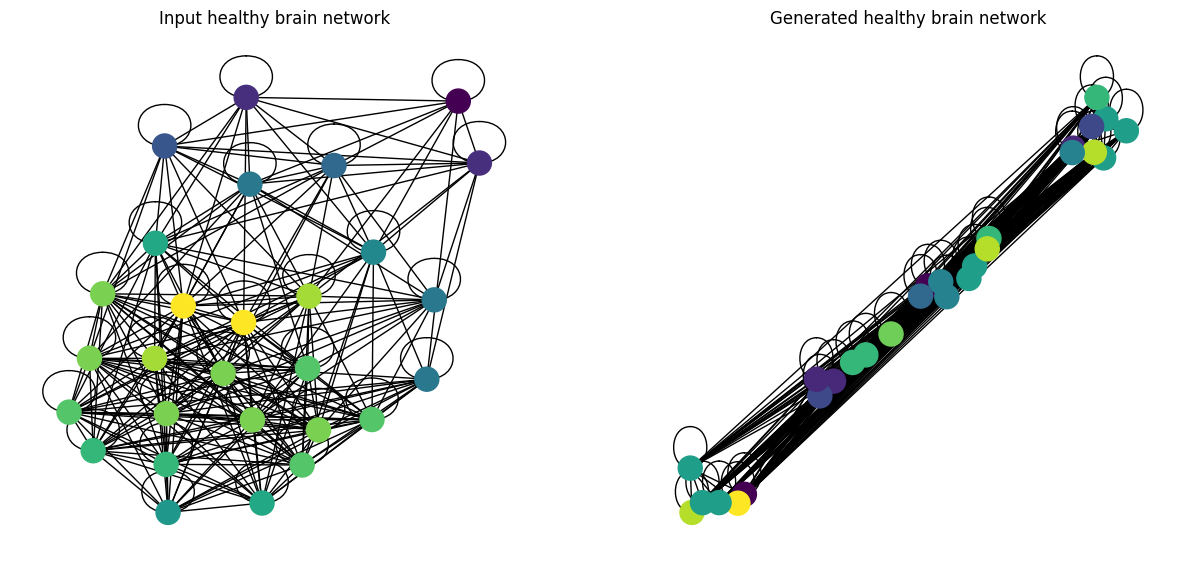

In [157]:
adj_label, adj_pred = np.ceil(h_label),np.ceil(h_preds[0])
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_label,221,"Input healthy brain network")
plot_graphs_spatial(g_pred,222,"Generated healthy brain network")

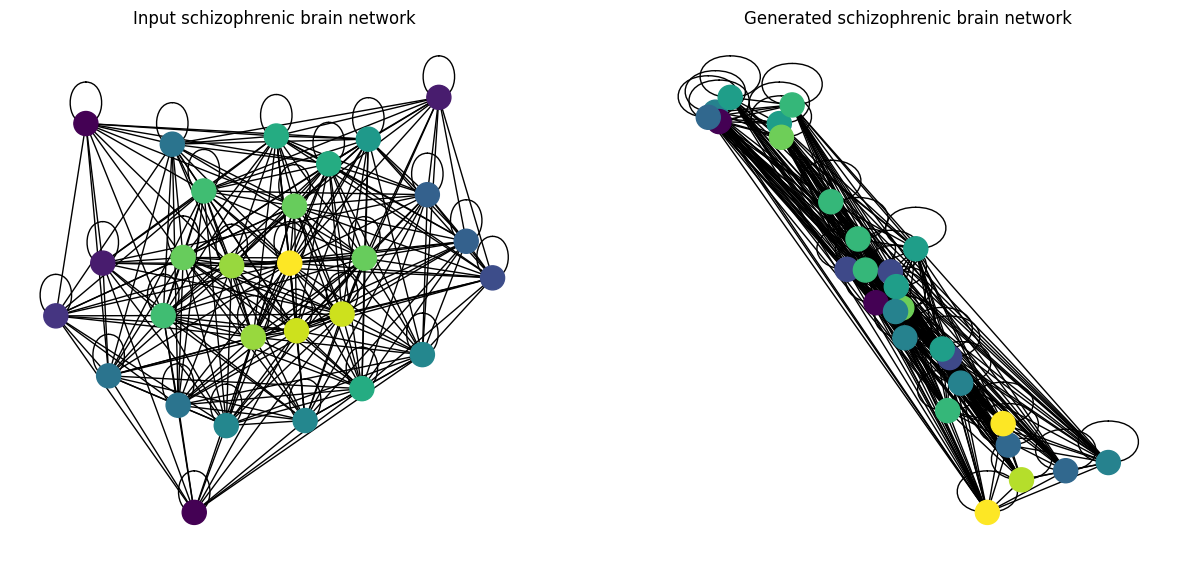

In [163]:
adj_label, adj_pred = np.ceil(s_label),np.ceil(s_preds[0])
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_label,221,"Input schizophrenic brain network")
plot_graphs_spatial(g_pred,222,"Generated schizophrenic brain network")

Sources:
- Diffusion Model Tutorial: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=uuckjpW_k1LN